# Before running this notebook, make sure to download the weights and image samples from the following link: 
<a href='https://drive.google.com/file/d/1p3WJp6dH4q1O_loa-VQmoEfLNJPWkSCe/view?usp=sharing'> Click here to download the weights and samples </a> 

# Importing Libs

In [13]:
import matplotlib.pyplot as plt
from data import GenericDataset
from models import PosADANet
from util import TrainingStrategy
import torch

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_dtype(torch.float64)

# Setting up initial path varibles

In [15]:
grayscale_weights_path= './Sample/grayscale_model.pt'
outline_weights_path = './Sample/outline_model.pt'
color_weights_path = './Sample/color_model.pt'
data_path = './Sample/data_example'

     

# Loading the data

In [16]:

grayscale_set = GenericDataset(data_path, splat_size=3, cache=False,
                                            keys=['colors', 'light_sph_relative'], train_strategy=TrainingStrategy.GRAYSCALE)
outline_set = GenericDataset(data_path, splat_size=1, cache=False,
                                            keys=['colors', 'light_sph_relative'], train_strategy=TrainingStrategy.OUTLINE)

# Loading model

In [17]:
grayscale_model = PosADANet(input_channels=1, output_channels=1, n_style=grayscale_set.control_length(),
                          padding='zeros', bilinear=True,
                          nfreq=20, magnitude=10, nof_layers = 3,
                          style_enc_layers = 6, start_channels = 32
                          )



outline_model = PosADANet(input_channels=1, output_channels=1, n_style=outline_set.control_length(),
                          padding='zeros', bilinear=True,
                          nfreq=20, magnitude=10, nof_layers = 2,
                          style_enc_layers = 6, start_channels = 24
                          )


color_model =  PosADANet(input_channels=2, output_channels=4, n_style=outline_set.control_length(),
                          padding='zeros', bilinear=True,
                          nfreq=20, magnitude=10, nof_layers = 3,
                          style_enc_layers = 6, start_channels = 64
                          )


models = [grayscale_model, outline_model, color_model]
weights = [grayscale_weights_path, outline_weights_path, color_weights_path]
names = ['grayscale', 'outline', 'color']
for model, weight, name in zip(models, weights, names):
    print(f'loading wieghts for {name}')
    model.eval()
    model.load_state_dict(torch.load(weight, map_location="cpu"))
    model.to(device)
    model.train()


loading wieghts for grayscale
loading wieghts for outline
loading wieghts for color


# Predictions

In [18]:
from random import randint
image_idx = randint(0, len(grayscale_set))
_, color_gt, outline_gt, outline_z_buffer, outline_settings_vector = outline_set[image_idx]
_, _, grayscale_gt, grayscale_z_buffer, grayscale_settings_vector = grayscale_set[image_idx]
grayscale_z_buffer = grayscale_z_buffer.unsqueeze(0).to(device)
outline_z_buffer = outline_z_buffer.unsqueeze(0).to(device)
grayscale_settings_vector = grayscale_settings_vector.unsqueeze(0).to(device)
outline_settings_vector = outline_settings_vector.unsqueeze(0).to(device)

grayscale_prediction = grayscale_model(grayscale_z_buffer, grayscale_settings_vector)
outline_prediction = outline_model(outline_z_buffer, outline_settings_vector)
outline_prediction = torch.sigmoid(outline_prediction)
color_input = torch.cat([grayscale_prediction, outline_prediction], dim=1)
color_prediction = color_model(color_input, grayscale_settings_vector)


# Plotting the predictions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


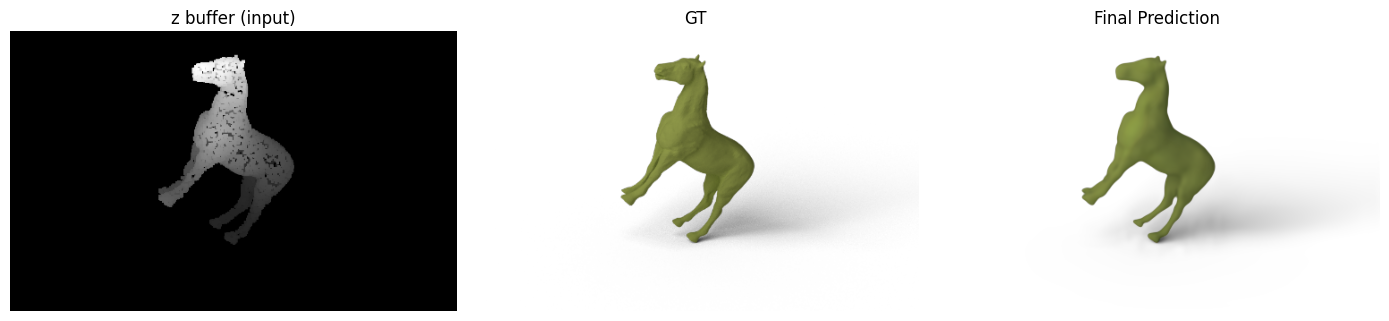

In [19]:
fig, ax = plt.subplots(1, 3, figsize=(14, 15))
ax[0].imshow(grayscale_z_buffer.squeeze().detach().cpu().numpy(), cmap='gray')
ax[0].set_title('z buffer (input)')
ax[1].imshow(color_gt.permute(1, 2, 0).detach().cpu().numpy())
ax[1].set_title('GT')
ax[2].imshow(color_prediction.squeeze().permute(1, 2, 0).detach().cpu().numpy())
ax[2].set_title('Final Prediction')
for axis in ax.flatten():
    axis.axis('off')
fig.tight_layout()